In [1]:
import os
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from adjustText import adjust_text

In [2]:
test_results_path ='./data/SWOW_prediction/eval/'
properties = ['previous_link','polarity']
model_name = 'bert-base-uncased'
reduces = ['forward','both','mean']
data_name = 'coha'
train_sections = np.arange(0, 5)
loss_function_name = 'likelihood_loss'
graph_strategy = 'ppmi'
token_strategy ='frequency'
graph_version = 2
swow_version = 1
fill = 'add'
add_self_loops = True
sections = ['dev','test']
baselines = [True, False]
property = 'previous_link' #Change to polarity to get the polarity results
mapping = {'previous_link': 'relevance',
           'polarity': 'polarity'} 
saving = mapping[property]
ends = {'previous_link': ['Low','High'],
        'polarity': ['Negative','Positive']}
labels = ends[property]

In [3]:
total_df = pd.DataFrame()
for train_section in range(0, 5):
    section = 'test'
    reduce = 'both'
    
    df_dir = test_results_path + f'{property}_{model_name}_{reduce}_{data_name}_{train_section}_{loss_function_name}_graph_{graph_strategy}_graph_version_{graph_version}_swow_version_{swow_version}_fill_{fill}_add_self_loops_{add_self_loops}_token_strategy_{token_strategy}_{section}.csv'             
    df = pd.read_csv(df_dir)
    df['section'] =[train_section] * len(df)
    mean_val = df['outputs'].mean()
    std_val = df['outputs'].std()
    df['z_score'] = df['outputs'].apply(lambda x : (x-mean_val) / std_val)
    total_df = pd.concat((total_df, df), ignore_index = True)
total_df =total_df.groupby(['words']).mean().reset_index()   
r, p = pearsonr(total_df.targets, total_df.z_score)
n = len(total_df)



In [4]:
k = 2
low_predicted = list(total_df.sort_values(by = 'z_score').head(70).sample(k).words)
high_predicted = list(total_df.sort_values(by = 'z_score').tail(70).sample(k).words)

low_empirical = list(total_df.sort_values(by = 'targets').head(70).sample(k).words)
high_empirical = list(total_df.sort_values(by = 'targets').tail(70).sample(k).words)
selected = low_empirical + high_predicted + low_empirical + high_empirical
neither = list(total_df.loc[~total_df.words.isin(selected)].sample(k).words)
[low_predicted, high_predicted,low_empirical,high_empirical,neither]

[['realist', 'bead'],
 ['exploitation', 'criminal'],
 ['arithmetic', 'time'],
 ['stolen', 'painful'],
 ['shower', 'academia']]

In [5]:
total_df.loc[total_df.words == 'divorce']

,words,targets,outputs,section,z_score
288,divorce,3.545975,3.26065,2.0,1.596831


In [6]:
selected += ['alcohol','smoking','divorce','sinner','unfair']

In [7]:
selected

['arithmetic',
 'time',
 'exploitation',
 'criminal',
 'arithmetic',
 'time',
 'stolen',
 'painful',
 'alcohol',
 'smoking',
 'divorce',
 'sinner',
 'unfair']

In [8]:
#relevance: 937, polarity: 843
len(total_df)

937

/tmp/ipykernel_2770038/204113278.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14)
/tmp/ipykernel_2770038/204113278.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)


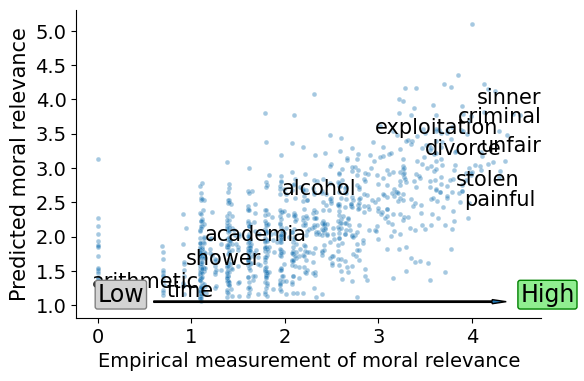

In [9]:
fig, ax = plt.subplots(figsize = (6, 4))


# sns.histplot(data = total_df, x = 'targets', y = 'z_score', ax = ax)
sns.scatterplot(data = total_df,x='targets', y='outputs',  s=12, color="tab:blue",ax= ax,alpha = 0.4)

# sns.scatterplot(data = total_df, x = 'targets', y = 'z_score',alpha = 0.3, ax = ax,color = 'black')
annotations = []
for i, row in df.iterrows():
    if row['words'] not in selected + neither :
        continue
    # random_choice = np.random.rand()
    # if random_choice >= .975:
    annotations.append(ax.text(x = row['targets'], y = row['outputs'], s= row['words'],size = 15))
          
adjust_text(annotations,expand=(0.5, 1),)
ax.text(x = total_df.targets.min() , y = total_df.outputs.min(), s = labels[0], color = 'Black',fontsize = 17,
        bbox=dict(facecolor='lightgrey', edgecolor='grey', boxstyle='round,pad=0.1'))

ax.text(x = total_df.targets.max(), y = total_df.outputs.min(), s = labels[1], color = 'Black',fontsize = 17,
       bbox=dict(facecolor='lightgreen', edgecolor='green', boxstyle='round,pad=0.1'))

plt.arrow(x = total_df.targets.min() + 0.6, y = total_df.outputs.min(),
          dx = total_df.targets.max() - total_df.targets.min() - 0.9,dy = 0,width=0.02,
         head_length = 0.15)

ax.set_ylabel(f'Predicted moral {saving}',fontsize = 15)
ax.set_xlabel(f'Empirical measurement of moral {saving}',fontsize = 14)
# ax.text(s ='a)', x = -1, y = 5.5, fontsize = 20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)

sns.despine()
# plt.savefig(f'notebooks/figs/coha_test_{saving}.png', dpi = 500, bbox_inches = 'tight')
# plt.savefig(f'notebooks/figs/coha_test_{saving}.pdf', dpi = 500, bbox_inches = 'tight')
plt.show()